In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
#cleaning, input, and output
class DataHandler:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.input_df = None
        self.output_df = None

    #read data
    def load_data(self):
        self.data = pd.read_csv(self.file_path)

    #drop column target
    def create_input_output(self, target_column):
        self.output_df = self.data[target_column]
        self.input_df = self.data.drop(target_column, axis=1)

    #check NA
    def check_missing_values(self):
        return self.data.isnull().sum()

    #check duplicated
    def check_duplicate_rows(self):
        return self.data.duplicated().sum()

    #handle duplicated
    def drop_duplicate_rows(self):
        self.data.drop_duplicates(inplace=True)

    #check structure
    def check_structure(self):
        return self.data.info()

    #check total unique value
    def check_unique_values(self):
        return self.data.nunique()

    #check distribution numerical columns
    def check_outlier(self):
        numeric_cols = self.data.select_dtypes(include=['number']).columns
        for col in numeric_cols:
            plt.figure(figsize=(5, 3))
            self.data.boxplot(column=[col])
            plt.title(f"Boxplot for {col}")
            plt.show()

In [ ]:
class ModelHandler:
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data
        self.createModel() 
        self.x_train, self.x_test, self.y_train, self.y_test, self.y_predict = [None] * 5 

    #encode :
    def label_encoder(self, columns):
        label_encoder = LabelEncoder()
        for column in columns:
            self.input_data[column] = label_encoder.fit_transform(self.input_data[column])

    def ordinal_encoder(self, columns_with_order):
        for column, categories in columns_with_order.items():
            ord_enc = OrdinalEncoder(categories=[categories])
            self.input_data[column] = ord_enc.fit_transform(self.input_data[[column]])

    def one_hot_encoder(self, columns):
        self.input_data = pd.get_dummies(self.input_data, columns=columns, dtype='int32')

    #split data
    def split_data(self, test_size = 0.2, random_state=42):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.input_data, self.output_data, test_size=test_size, random_state=random_state)
        print(self.x_train.shape,self.x_test.shape), print(self.y_train.shape,self.y_test.shape)
        print(self.y_train.value_counts())

    #scaler
    def std_scaler(self, columns):
        std_scaler = StandardScaler()
        self.x_train[columns] = std_scaler.fit_transform(self.x_train[columns])
        self.x_test[columns] = std_scaler.transform(self.x_test[columns])

    def rob_scaler(self, columns):
        rob_scaler = RobustScaler()
        self.x_train[columns] = rob_scaler.fit_transform(self.x_train[columns])
        self.x_test[columns] = rob_scaler.transform(self.x_test[columns])

    #modeling
    def createModel(self, criteria = 'gini', maxdepth=6):
        self.model = RandomForestClassifier(criterion=criteria, max_depth=maxdepth)

    def train_model(self):
        self.model.fit(self.x_train, self.y_train)

    def makePrediction(self):
        self.y_predict = self.model.predict(self.x_test)
        self.y_predict_proba = self.model.predict_proba(self.x_test)

    def get_prediction_df(self):
        class_labels = self.model.classes_
        probabilities_df = pd.DataFrame(self.y_predict_proba, columns=class_labels)

        probabilities_df = probabilities_df.round(4)

        return probabilities_df

    #evaluation
    def createReport(self):
        print("\n Classification Report:\n")
        print(classification_report(self.y_test, self.y_predict, target_names=[
            'Insufficient Weight', 'Normal Weight', 'Overweight Level I',
            'Overweight Level II', 'Obesity Type I', 'Obesity Type II', 'Obesity Type III'
        ]))

    def evaluate_model(self):
        #predictions = self.model.predict(self.x_test)
        return accuracy_score(self.y_test, self.y_predict)

    #gridsearch
    def tuningParameter(self):
        parameters = {'criterion' : ['gini', 'entropy', 'log_loss'], 'max_depth' : [2,4,6,8]}
        RFClass = RandomForestClassifier()
        RFClass = GridSearchCV(RFClass, scoring='accuracy', param_grid=parameters, cv=5)

        RFClass.fit(self.x_train, self.y_train)

        print("Tuned HyperParameters ", RFClass.best_params_)
        print("Accuracy: ", RFClass.best_score_)

        self.createModel(criteria=RFClass.best_params_['criterion'], maxdepth=RFClass.best_params_['max_depth'])

    #save model
    def save_model_to_file(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.model, file)

<class 'pandas.core.frame.DataFrame'>
Index: 2087 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2087 non-null   object 
 1   Age                             2087 non-null   int64  
 2   Height                          2087 non-null   float64
 3   Weight                          2087 non-null   float64
 4   family_history_with_overweight  2087 non-null   object 
 5   FAVC                            2087 non-null   object 
 6   FCVC                            2087 non-null   float64
 7   NCP                             2087 non-null   float64
 8   CAEC                            2087 non-null   object 
 9   SMOKE                           2087 non-null   object 
 10  CH2O                            2087 non-null   float64
 11  SCC                             2087 non-null   object 
 12  FAF                             2087 no

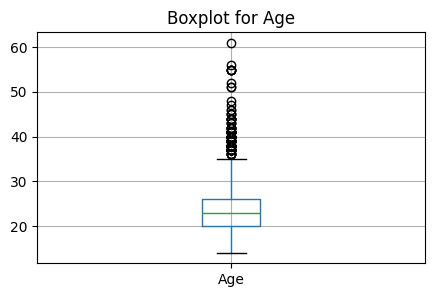

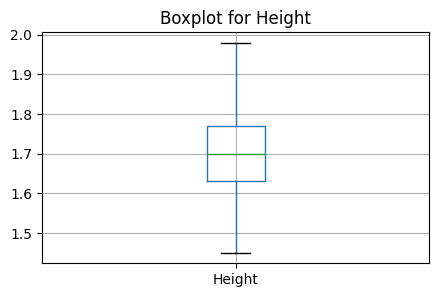

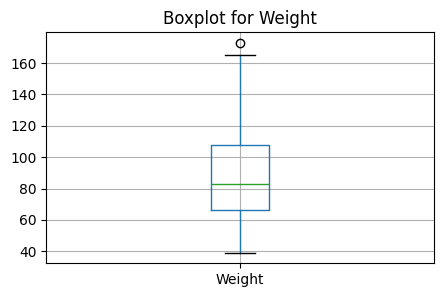

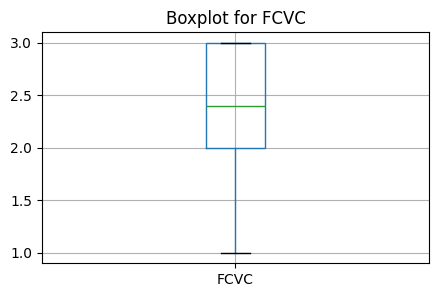

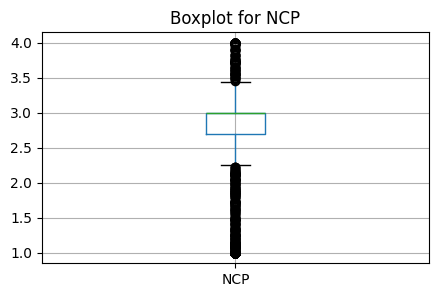

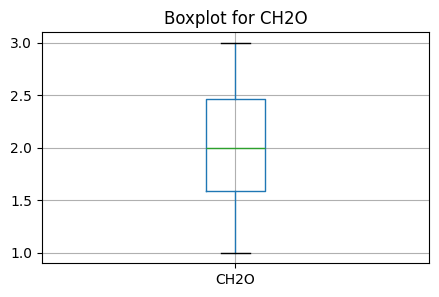

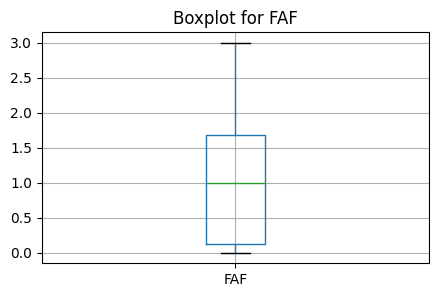

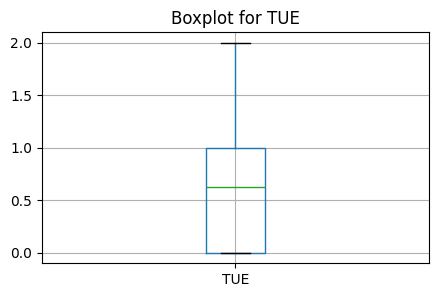

In [ ]:
#1. load data
file_path = '/content/ObesityDataSet_raw_and_data_sinthetic.csv'
data_handler = DataHandler(file_path)
data_handler.load_data()

#2. check missing values and duplicates
data_handler.check_missing_values()
data_handler.check_duplicate_rows()

#3. delete duplicates
data_handler.drop_duplicate_rows()

#4. split input and output
data_handler.create_input_output("NObeyesdad")
data_handler.check_structure()

#5. data unique
data_handler.check_unique_values()

#6. outlier check
data_handler.check_outlier()

In [6]:
#5. split
input_df = data_handler.input_df
output_df = data_handler.output_df

In [7]:
model_handler = ModelHandler(input_df, output_df)

In [8]:
#encode :
label_columns = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
model_handler.label_encoder(label_columns)

ordinal_columns = {
    "CAEC": ["no", "Sometimes", "Frequently", "Always"],
    "CALC": ["no", "Sometimes", "Frequently", "Always"]
    }
model_handler.ordinal_encoder(ordinal_columns)

one_hot_columns = ["MTRANS"]
model_handler.one_hot_encoder(one_hot_columns)

In [ ]:
#check after encode
model_handler.input_data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,21,1.62,64.00,1,0,2.0,3.0,1.0,0,2.00,0,0.00,1.000,0.0,0,0,0,1,0
1,0,21,1.52,56.00,1,0,3.0,3.0,1.0,1,3.00,1,3.00,0.000,1.0,0,0,0,1,0
2,1,23,1.80,77.00,1,0,2.0,3.0,1.0,0,2.00,0,2.00,1.000,2.0,0,0,0,1,0
3,1,27,1.80,87.00,0,0,3.0,3.0,1.0,0,2.00,0,2.00,0.000,2.0,0,0,0,0,1
4,1,22,1.78,89.80,0,0,2.0,1.0,1.0,0,2.00,0,0.00,0.000,1.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,21,1.71,131.41,1,1,3.0,3.0,1.0,0,1.73,0,1.68,0.906,1.0,0,0,0,1,0
2107,0,22,1.75,133.74,1,1,3.0,3.0,1.0,0,2.01,0,1.34,0.599,1.0,0,0,0,1,0
2108,0,23,1.75,133.69,1,1,3.0,3.0,1.0,0,2.05,0,1.41,0.646,1.0,0,0,0,1,0
2109,0,24,1.74,133.35,1,1,3.0,3.0,1.0,0,2.85,0,1.14,0.586,1.0,0,0,0,1,0


In [10]:
model_handler.split_data()

(1669, 20) (418, 20)
(1669,) (418,)
NObeyesdad
Obesity_Type_I         281
Obesity_Type_III       264
Overweight_Level_II    241
Obesity_Type_II        233
Normal_Weight          221
Overweight_Level_I     221
Insufficient_Weight    208
Name: count, dtype: int64


In [ ]:
#outlier use robust scaler
model_handler.rob_scaler(["Age", "NCP" ,"Weight"])

#normal use standard scaler
model_handler.std_scaler(["Height", "FCVC", "CH2O", "FAF", "TUE"])

In [12]:
print("Before Tuning Parameter")
model_handler.train_model()
model_handler.makePrediction()
print("Model Accuracy: ", model_handler.evaluate_model())
model_handler.createReport()

Before Tuning Parameter
Model Accuracy:  0.8995215311004785

 Classification Report:

                     precision    recall  f1-score   support

Insufficient Weight       0.93      0.92      0.92        59
      Normal Weight       0.81      0.82      0.81        61
 Overweight Level I       0.90      0.91      0.91        70
Overweight Level II       0.98      1.00      0.99        64
     Obesity Type I       1.00      1.00      1.00        60
    Obesity Type II       0.88      0.80      0.84        55
   Obesity Type III       0.77      0.82      0.79        49

           accuracy                           0.90       418
          macro avg       0.90      0.90      0.90       418
       weighted avg       0.90      0.90      0.90       418



In [13]:
print("After Tuning Parameter")
model_handler.tuningParameter()
model_handler.train_model()
model_handler.makePrediction()
print("\nModel Accuracy: ", model_handler.evaluate_model())
model_handler.createReport()

After Tuning Parameter
Tuned HyperParameters  {'criterion': 'log_loss', 'max_depth': 8}
Accuracy:  0.9335023646400892

Model Accuracy:  0.9449760765550239

 Classification Report:

                     precision    recall  f1-score   support

Insufficient Weight       0.96      0.93      0.95        59
      Normal Weight       0.85      0.90      0.87        61
 Overweight Level I       0.97      0.97      0.97        70
Overweight Level II       1.00      1.00      1.00        64
     Obesity Type I       1.00      1.00      1.00        60
    Obesity Type II       0.92      0.85      0.89        55
   Obesity Type III       0.90      0.94      0.92        49

           accuracy                           0.94       418
          macro avg       0.94      0.94      0.94       418
       weighted avg       0.95      0.94      0.95       418



In [14]:
model_handler.save_model_to_file("trained_model.pkl")